In [1]:
'''
loading libs
'''
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
loading images
'''
nevus_filepath = 'data/0/'
melanoma_filepath = 'data/1/'

nevus_files = [f for f in os.listdir(nevus_filepath) if os.path.isfile(nevus_filepath+f)]
melanoma_files = [f for f in os.listdir(melanoma_filepath) if os.path.isfile(melanoma_filepath+f)]
# sort filenames
nevus_files = sorted(nevus_files)
melanoma_files = sorted(melanoma_files)

N = 1000
nevus_imgs = [plt.imread(os.path.join(nevus_filepath, nevus_files[i])) for i in range(N)]
melanoma_imgs = [plt.imread(os.path.join(melanoma_filepath, melanoma_files[i])) for i in range(N)]

# resize
nevus_imgs = [cv2.resize(img,(256,256)) for img in nevus_imgs]
melanoma_imgs = [cv2.resize(img,(256,256)) for img in melanoma_imgs]

In [7]:
'''
Define clustering of colors in image
'''
from sklearn.utils import shuffle
from sklearn.cluster import KMeans

def cluster_image(img, n_colors):
    if img.max() > 1:
        img = img / 255
        
    image_array = img.reshape(img.shape[0]*img.shape[1],1)
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

    # Get labels for all points
    labels = kmeans.predict(image_array)

    def recreate_image(codebook, labels, w, h):
        """Recreate the (compressed) image from the code book & labels"""
        d = codebook.shape[1]
        image = np.zeros((w, h))
        label_idx = 0
        for i in range(w):
            for j in range(h):
                image[i][j] = codebook[labels[label_idx]]
                label_idx += 1
        return image
    return recreate_image(kmeans.cluster_centers_, labels, img.shape[0], img.shape[1])

In [8]:
'''
make clustered images. For SMALL TEST data
'''
n_colors = 3

nc_imgs = []
mc_imgs = []

for img in nevus_imgs:
    nc_img = cluster_image(img, n_colors)
    nc_imgs += [nc_img]
    
for img in melanoma_imgs:
    mc_img = cluster_image(img, n_colors)
    mc_imgs += [mc_img]

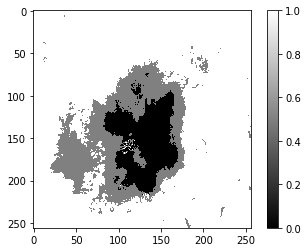

In [10]:
'''
Scaling all values into 3 values
'''
def map_3color_imgs(c_imgs):
    map_val = [0, 0.5, 1]
    new_imgs = []
    for i in range(len(c_imgs)): 
        img = c_imgs[i]
        u_val = sorted(np.unique(img))
        img[img == u_val[0]] = map_val[0]
        img[img == u_val[1]] = map_val[1]
        img[img == u_val[2]] = map_val[2]

        new_imgs += [img]
    return new_imgs

n_imgs = map_3color_imgs(nc_imgs)
m_imgs = map_3color_imgs(mc_imgs)

plt.imshow(n_imgs[999], 'gray')
plt.colorbar()

In [133]:
'''
FFT of the images
'''
def norm_dft2(dft2):
    c = 255 / np.log(1 + max(abs(dft2.flatten())))
    result = c * np.log(1 + abs(dft2))
    return result

# Data feature extruction
def compute_fft(img):
    fft = np.fft.fft2(img)
    return norm_dft2(np.fft.fftshift(fft).real)
    
n_fft = [compute_fft(img) for img in n_imgs]
m_fft = [compute_fft(img) for img in m_imgs]

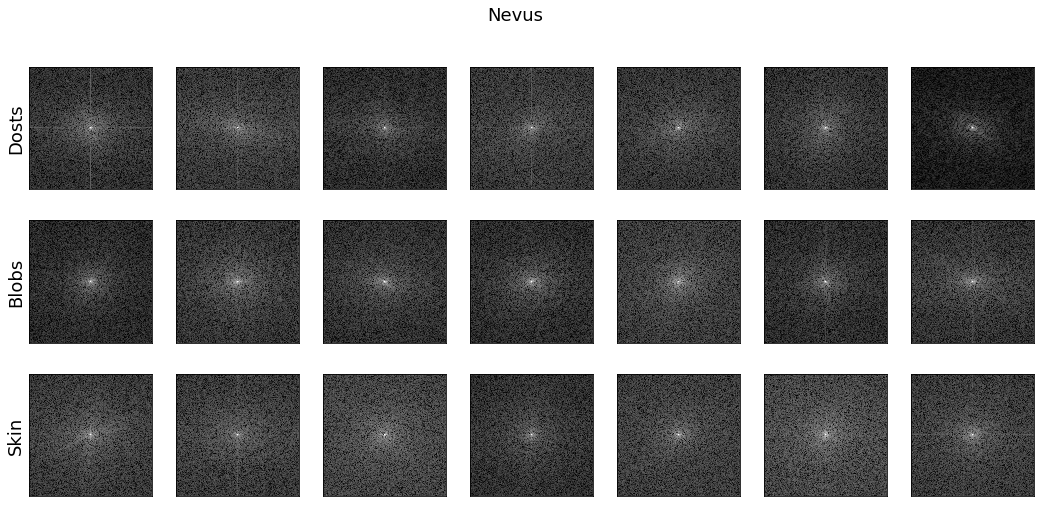

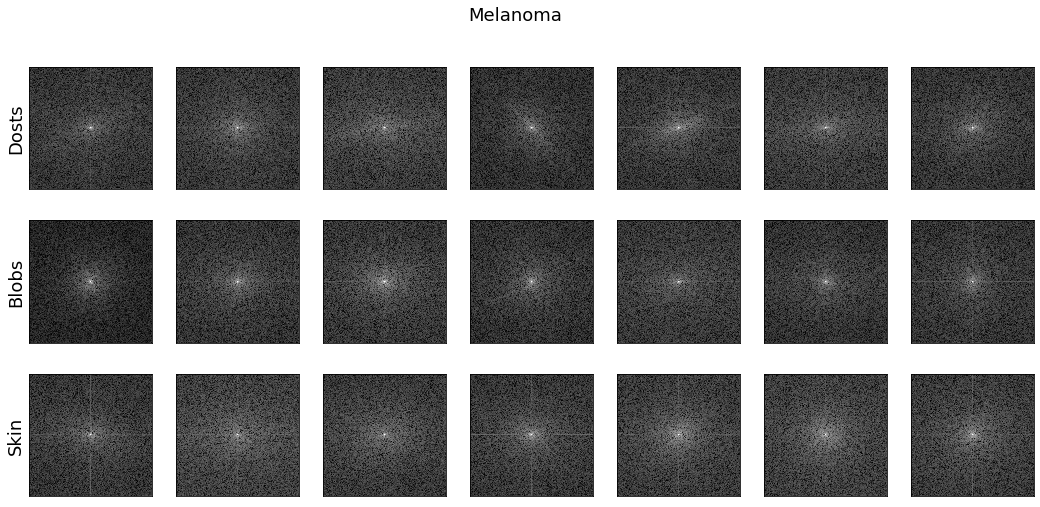

In [134]:
# defenetly dots, blobs, skin for nevus
n_dots =  [13,19,33,35,43,63,89]
n_blobs = [0, 1, 3, 7, 20,28,34]
n_skin =  [11,27,44,50,52,68,55]

# defenetly dots, blobs, skin for melanoma
m_dots =  [6,8,15,16,29,34,46]
m_blobs = [1,3,7, 10,11,21,41]
m_skin =  [4,5,9, 13,14,26,40]

# plot
def dot_blobs_skin_plot(dots,blobs,skin,imgs,title=''):
    N = 7
    fig, ax = plt.subplots(3,N, figsize=(18,8))
    for i in range(N):
        ax[0,i].imshow(imgs[dots[i]], 'gray')
        ax[0,i].set_yticks([])
        ax[0,i].set_xticks([])
    ax[0,0].set_ylabel('Dosts', size=18)
    for i in range(N):
        ax[1,i].imshow(imgs[blobs[i]], 'gray')
        ax[1,i].set_yticks([])
        ax[1,i].set_xticks([])
    ax[1,0].set_ylabel('Blobs', size=18)
    for i in range(N):
        ax[2,i].imshow(imgs[skin[i]], 'gray')
        ax[2,i].set_yticks([])
        ax[2,i].set_xticks([])
    ax[2,0].set_ylabel('Skin', size=18)
    fig.suptitle(title, size=18)


dot_blobs_skin_plot(n_dots,n_blobs,n_skin,n_fft, 'Nevus')
dot_blobs_skin_plot(m_dots,m_blobs,m_skin,m_fft, 'Melanoma')

# CNN

In [11]:
import tensorflow

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

print(tensorflow.__version__)
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

tensorflow.debugging.set_log_device_placement(True)
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(gpus[0], True)

1.15.2
Num GPUs Available:  1


In [113]:
'''
Split data
'''
from sklearn.model_selection import train_test_split

X = np.array([img.reshape(256,256,1) for img in n_imgs+m_imgs])
y = np.zeros(X.shape[0])
y[:1000] = 1

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [44]:
'''
Define plot training function
'''
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [125]:
# My model
model = models.Sequential()
# model.add(layers.Conv2D(32, (4,4), activation='relu', input_shape=(256,256,1)))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(64,(3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(128,(3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(128,(3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

model.add(layers.Conv2D(32, (2,2), activation='relu', input_shape=(256,256,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(128,(3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

          
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 255, 255, 32)      160       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 126, 126, 64)      8256      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 62, 62, 128)       32896     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 123008)          

In [126]:
history = model.fit(
    X_train,
    y_train,
    epochs = 50,
    validation_split=0.2)

Train on 1280 samples, validate on 320 samples
Epoch 1/50
1280/1280 [==============================] - 3s 2ms/sample - loss: 0.7850 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.4781
Epoch 2/50
1280/1280 [==============================] - 2s 1ms/sample - loss: 0.6929 - acc: 0.5711 - val_loss: 0.6949 - val_acc: 0.4531
Epoch 3/50
1280/1280 [==============================] - 2s 1ms/sample - loss: 0.6845 - acc: 0.5562 - val_loss: 0.6964 - val_acc: 0.4625
Epoch 4/50
1280/1280 [==============================] - 2s 2ms/sample - loss: 0.6398 - acc: 0.6203 - val_loss: 0.7188 - val_acc: 0.5531
Epoch 5/50
1280/1280 [==============================] - 2s 2ms/sample - loss: 0.5331 - acc: 0.7359 - val_loss: 0.8162 - val_acc: 0.4938
Epoch 6/50
1280/1280 [==============================] - 2s 2ms/sample - loss: 0.3781 - acc: 0.8211 - val_loss: 0.9499 - val_acc: 0.4812
Epoch 7/50
1280/1280 [==============================] - 2s 1ms/sample - loss: 0.2354 - acc: 0.9023 - val_loss: 1.4322 - val_acc: 0.4875
E

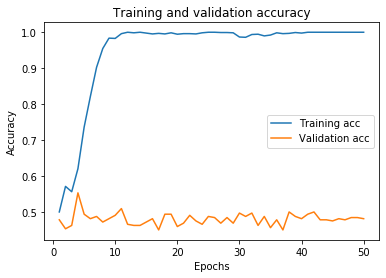

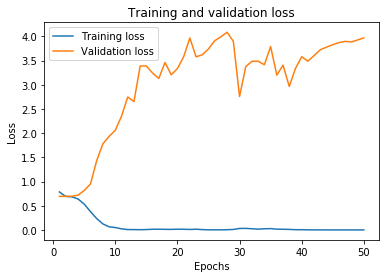

In [127]:
plot_history(history)

In [128]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test acc:", test_acc)
print("test loss:", test_loss)

400/400 [==============================] - 0s 943us/sample - loss: 4.2584 - acc: 0.5075
test acc: 0.5075
test loss: 4.258432950973511


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pydot, pydotplus
import graphviz
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)
model.save('acc81.h5')

# Random forest

In [135]:
from hilbertcurve.hilbertcurve import HilbertCurve

def get_flat_coords(a):
    # Compute HilbertCurve for 256x256 img
    p=9; N=2
    hilbert_curve = HilbertCurve(p, N)
    flat_coords = []
    for ii in range(a**2):
        coords = hilbert_curve.coordinates_from_distance(ii)
    #     print(f'coords(h={ii}) = {coords}')
        flat_coords += [coords]
    flat_coords = np.array(flat_coords)
    return flat_coords

def hilbert_flat(img, flat_coords):
    flatten_image = []
    for x,y in flat_coords:
        flatten_image += [img[x,y]]

    return np.array(flatten_image)

In [137]:
'''
Flatten images with hilbert curve
'''

fc = get_flat_coords(256)
flat_nc_imgs = [hilbert_flat(img,fc) for img in n_fft]
flat_mc_imgs = [hilbert_flat(img,fc) for img in m_fft]

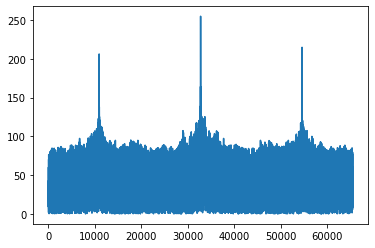

In [145]:
plt.plot(flat_mc_imgs[50])

In [141]:
from sklearn.manifold import TSNE
embedded = TSNE(n_components=3, n_jobs=-1).fit_transform(flat_nc_imgs+flat_mc_imgs)

In [143]:
import plotly.graph_objects as go
data = embedded

n = go.Scatter3d(x=data[:700,0], y=data[:1000,1], z=data[:1000,2], 
                 mode='markers',
                 name='nevus',
                 marker=dict(
                     color='rgb(255,169,34)',
                     size=3,
                     opacity=0.8))

m = go.Scatter3d(x=data[700:,0], y=data[1000:,1], z=data[1000:,2], 
                 mode='markers',
                 name='melanomas',
                 marker=dict(
                     color='rgb(83,97,255)',
                     size=3,
                     opacity=0.8))

fig = go.Figure(data=[n,m])
fig.update_layout(
    title_text='3D projection',
    height=800,
    width=800
)
fig.show()

In [146]:
'''
Split data
'''
from sklearn.model_selection import train_test_split

X = np.array(flat_nc_imgs+flat_mc_imgs)
y = np.zeros(X.shape[0])
y[:1000] = 1

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [155]:
from sklearn.ensemble import RandomForestClassifier
# 6
clf = RandomForestClassifier(max_depth=3, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.8725

In [156]:
clf.score(X_test, y_test)

0.5325

In [96]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=10)
scores = cross_val_score(clf, X_train, y_train, cv=2)
scores.mean()

TypeError: __init__() got an unexpected keyword argument 'n_jobs'

In [98]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
scores = cross_val_score(lr, X_train, y_train, cv=2)
scores.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.5081249999999999

In [103]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores.mean()

0.520625

In [105]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
scores = cross_val_score(nb, X_train, y_train, cv=5)
scores.mean()

0.514375

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.54 (+/- 0.03) [Logistic Regression]
Accuracy: 0.53 (+/- 0.02) [Random Forest]
Accuracy: 0.51 (+/- 0.01) [naive Bayes]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.54 (+/- 0.03) [Ensemble]


In [109]:
# XGBoost
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic'}
num_round = 40

bst = xgb.train(param, dtrain, num_round)

preds = bst.predict(dtest)
np.sum(np.round(preds) == y_test) / len(y_test)

0.4675